# Projeto 3 - Rating de filmes (IMDB)

<img src="imdb.jpg"/, width=500, height=400 style="float: center; margin: 0px 0px 10px 10px">

#### Membros: Marcelo Lisboa de Castro Reis, Tiago Niemeyer Bergamo  e Bruno Kaczelnik - 2C Engenharia Insper

Esse projeto se trata de um classificador, o qual é baseado no elenco, diretores, gêneros do filme, bilheteria e entre outras variáveis, pretendemos avaliar qual será a classificação que um filme receberá.

Para isso, foi selecionado o DataSet “imdb-5000-movie-staset”, encontrado no site Kaggle, no qual se encontram aproximadamente 3760 filmes, cada um possuindo três atores principais, um diretor, diversos gêneros, entre outros indicadores. 

A ideia original do projeto era ser capaz de devolver a nota exata que um filme receberia utilizando regressão, entretanto, devido ao curto intervalo no qual a nota poderia ser dada, zero a dez, o modelo seria incapaz de acertar com precisão, ocorrendo diversas extrapolações. Assim, resolvemos utilizar classificação e para isso dividimos os filmes dentre 5 divisões (Muito Bom, Bom, Neutro, Ruim e Muito Ruim). 

Foi necessário então fazer uma análise exploratória dos dados desse dataset para selecionar apenas as variáveis que seriam úteis para o nosso modelo de Rating de filmes. A análise segue abaixo:

## Imports:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Criando o dataframe:

In [2]:
#Criando o dataframe
imdb = pd.read_csv('movie_metadata.csv')
imdb["movie_title"] = [k.replace("\xa0","") for k in imdb["movie_title"]]
imdb = imdb.dropna(0)
imdb = imdb.set_index('movie_title')
imdb = imdb.drop(['aspect_ratio','movie_imdb_link','facenumber_in_poster','plot_keywords'], axis=1)
imdb.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,actor_3_name,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
movie_title,,,,,,,,,,,,,,,,,,,,,
Avatar,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,Wes Studi,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000
Pirates of the Caribbean: At World's End,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,Jack Davenport,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,0
Spectre,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,Stephanie Sigman,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,85000
The Dark Knight Rises,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,Joseph Gordon-Levitt,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,164000
John Carter,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,Polly Walker,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,24000


In [3]:
imdb = imdb.applymap(lambda x: x if type(x)!=str else x.replace(" ","_"))

In [4]:
imdb.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,actor_3_name,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
movie_title,,,,,,,,,,,,,,,,,,,,,
Avatar,Color,James_Cameron,723.0,178.0,0.0,855.0,Joel_David_Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,Wes_Studi,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000
Pirates of the Caribbean: At World's End,Color,Gore_Verbinski,302.0,169.0,563.0,1000.0,Orlando_Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,Jack_Davenport,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,0
Spectre,Color,Sam_Mendes,602.0,148.0,0.0,161.0,Rory_Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,Stephanie_Sigman,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,85000
The Dark Knight Rises,Color,Christopher_Nolan,813.0,164.0,22000.0,23000.0,Christian_Bale,27000.0,448130642.0,Action|Thriller,...,Joseph_Gordon-Levitt,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,164000
John Carter,Color,Andrew_Stanton,462.0,132.0,475.0,530.0,Samantha_Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,Polly_Walker,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,24000


## Análise Exploratória: ##

Inicialmente haviam 5043 filmes com 27 colunas cada, e apenas avaliando o nome de algumas dessas colunas já foi possível perceber se seriam irrelevantes ou não para o nosso modelo. Assim já foram descartados os indicadores 'aspect_ratio', 'movie_imdb_link', 'plot_keywords' e 'facenumber_in_poster'.

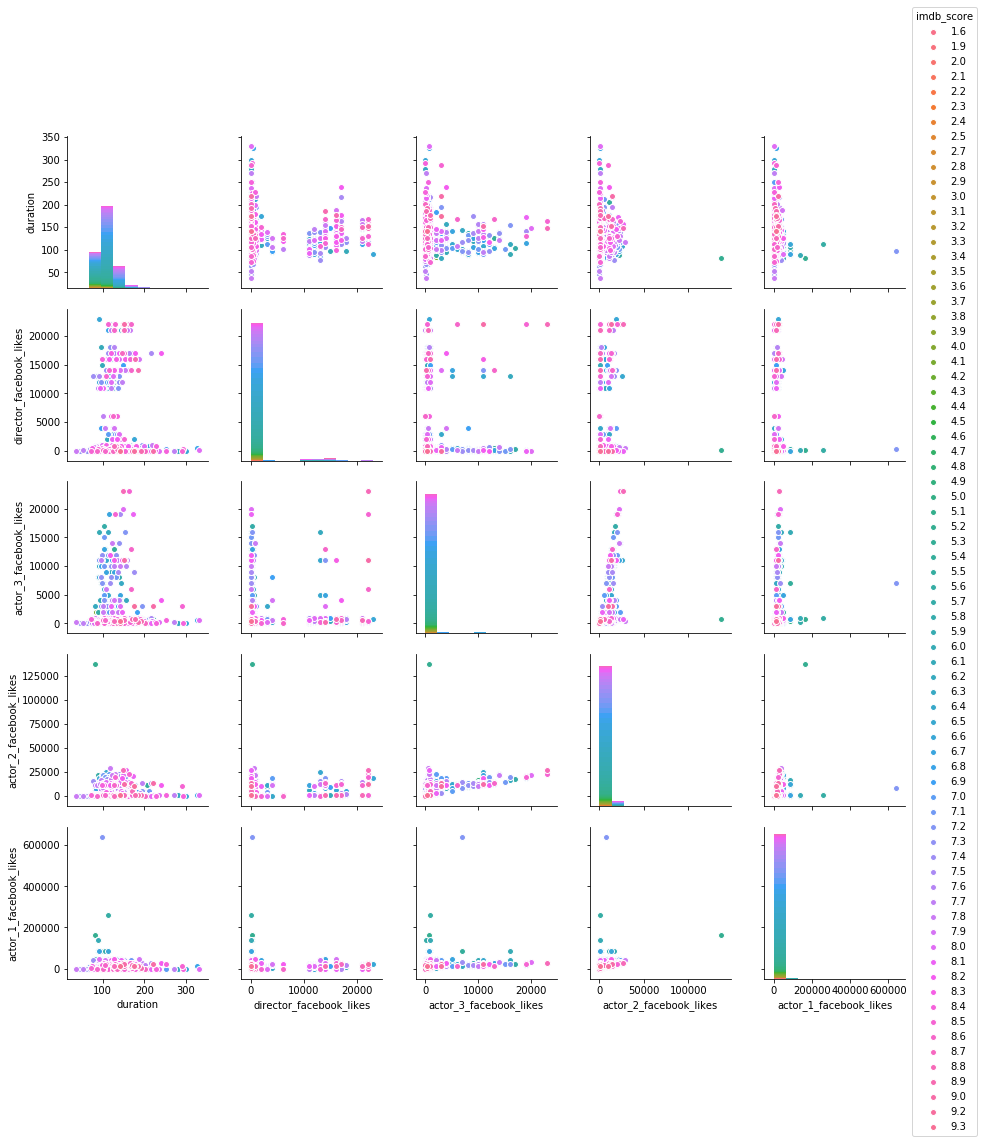

In [5]:
sns.pairplot(imdb, vars=['duration','director_facebook_likes','actor_3_facebook_likes','actor_2_facebook_likes',
                         'actor_1_facebook_likes'], hue='imdb_score')

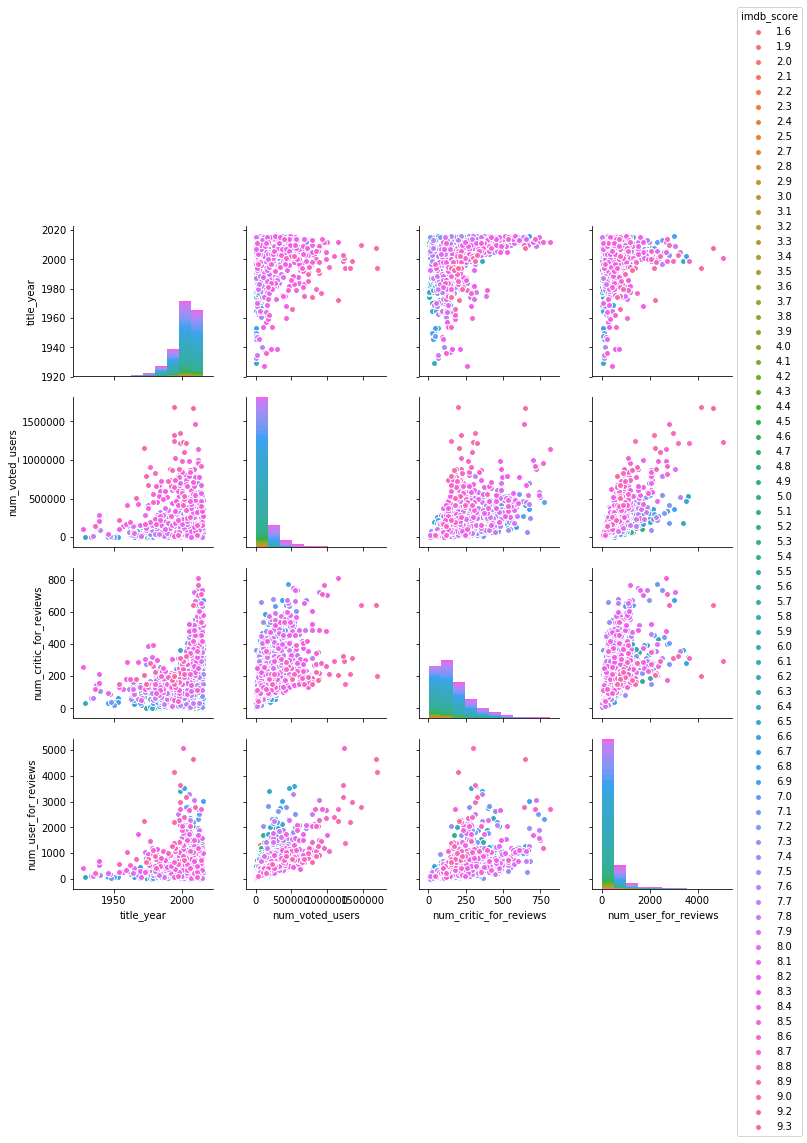

In [6]:
sns.pairplot(imdb, vars=['title_year','num_voted_users','num_critic_for_reviews',
                        'num_user_for_reviews'], hue='imdb_score')

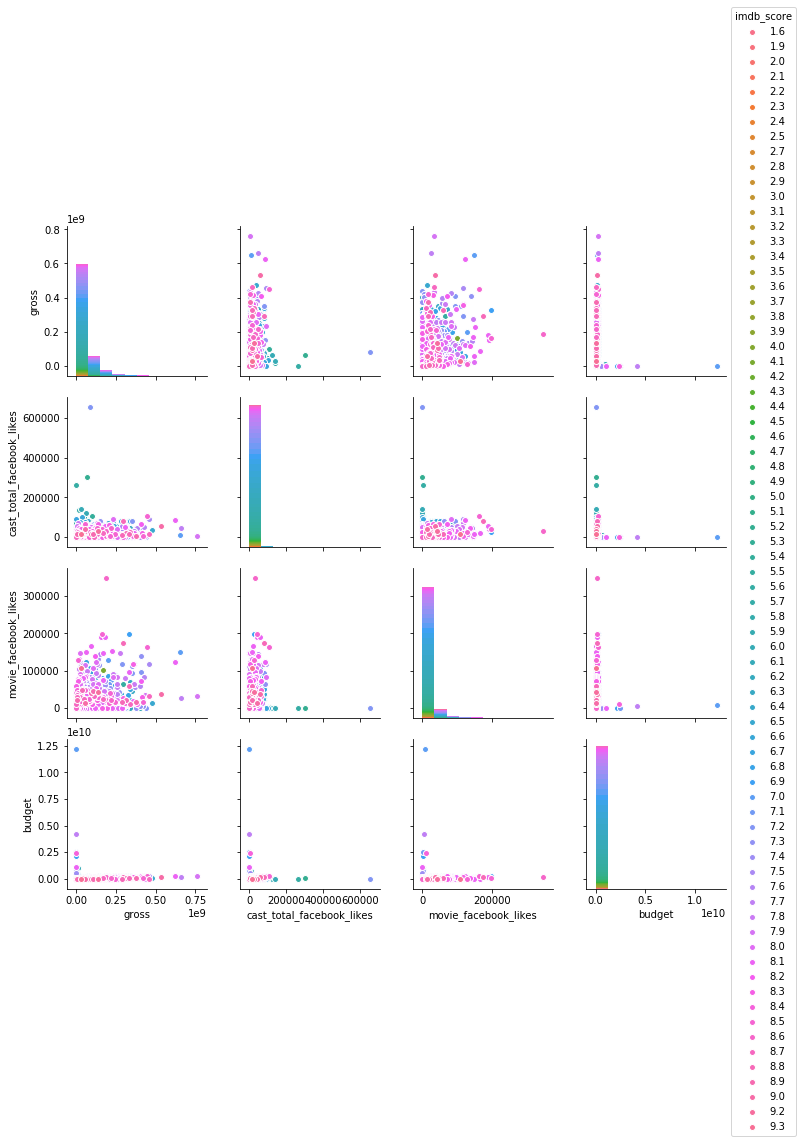

In [7]:
sns.pairplot(imdb, vars=['gross','cast_total_facebook_likes','movie_facebook_likes','budget'], hue='imdb_score')

Observando os pairplots, vimos que diversos indicadores tem em grande maioria, principalmente os relacionados com likes, valores iguais a zero. Portanto decidimos que seria melhor descartá-los por insuficiência de dados para análise.

In [8]:
imdb.corr()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
num_critic_for_reviews,1.000000,0.228631,0.175128,0.252782,0.165986,0.464187,0.592473,0.236533,0.563684,0.104717,0.420202,0.253125,0.347886,0.705226
duration,0.228631,1.000000,0.180644,0.125797,0.083632,0.245726,0.339592,0.120179,0.351595,0.068012,-0.130211,0.128935,0.366221,0.215303
director_facebook_likes,0.175128,0.180644,1.000000,0.117405,0.089630,0.138351,0.299624,0.118547,0.217103,0.018167,-0.044656,0.116058,0.192314,0.161962
actor_3_facebook_likes,0.252782,0.125797,0.117405,1.000000,0.252408,0.299864,0.267762,0.489795,0.205343,0.039966,0.117475,0.553755,0.065544,0.271508
actor_1_facebook_likes,0.165986,0.083632,0.089630,0.252408,1.000000,0.144010,0.179590,0.944813,0.121935,0.016418,0.096194,0.391166,0.093597,0.130300
gross,0.464187,0.245726,0.138351,0.299864,0.144010,1.000000,0.624949,0.235601,0.544674,0.099496,0.054808,0.252842,0.214740,0.366933
num_voted_users,0.592473,0.339592,0.299624,0.267762,0.179590,0.624949,1.000000,0.249119,0.778881,0.065927,0.023687,0.244822,0.482430,0.517751
cast_total_facebook_likes,0.236533,0.120179,0.118547,0.489795,0.944813,0.235601,0.249119,1.000000,0.178675,0.028682,0.127045,0.642991,0.106803,0.205564
num_user_for_reviews,0.563684,0.351595,0.217103,0.205343,0.121935,0.544674,0.778881,0.178675,1.000000,0.070372,0.019470,0.187016,0.325003,0.370465
budget,0.104717,0.068012,0.018167,0.039966,0.016418,0.099496,0.065927,0.028682,0.070372,1.000000,0.047138,0.035715,0.029190,0.052490


Além disso, olhando as correlações, podemos perceber que tanto o "actor_1_facebook_likes" e "cast_total_facebook_likes" como o "num_voted_users" e "num_user_for_reviews" estão com correlações altíssimas, o que quer dizer que podemos desconsiderar uma das  colunas, pois uma pode explicar a outra. 

In [9]:
imdb_ = imdb.drop(['num_voted_users','num_voted_users','director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'budget', 'movie_facebook_likes'], axis=1)
imdb_.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'actor_2_name', 'gross', 'genres', 'actor_1_name', 'actor_3_name',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score'],
      dtype='object')

In [10]:
print(imdb_["color"].value_counts())
print(imdb_["language"].value_counts())
print(imdb_["country"].value_counts())
print(imdb_["content_rating"].value_counts())

Color               3632
_Black_and_White     124
Name: color, dtype: int64
English       3598
French          34
Spanish         23
Mandarin        15
German          10
Japanese        10
Italian          7
Cantonese        7
Hindi            5
Portuguese       5
Korean           5
Norwegian        4
Persian          3
Danish           3
Dutch            3
Thai             3
Aboriginal       2
Dari             2
Indonesian       2
Aramaic          1
Zulu             1
Hebrew           1
Arabic           1
Maya             1
Romanian         1
Czech            1
None             1
Mongolian        1
Vietnamese       1
Bosnian          1
Filipino         1
Kazakh           1
Russian          1
Hungarian        1
Name: language, dtype: int64
USA               2987
UK                 318
France             101
Germany             80
Canada              59
Australia           39
Spain               21
Japan               15
China               13
Hong_Kong           13
New_Zealand        

Utilizando o value_counts do pandas para ver a proporção dos indicadores, novamente por insuficiência de dados para análise, resolvemos que seria melhor descartar "color", "language" e "country".

In [11]:
imdb_ = imdb_.drop(['language','country','color'], axis=1)

Estes são os indicadores que foram mantidos após os pairplots:

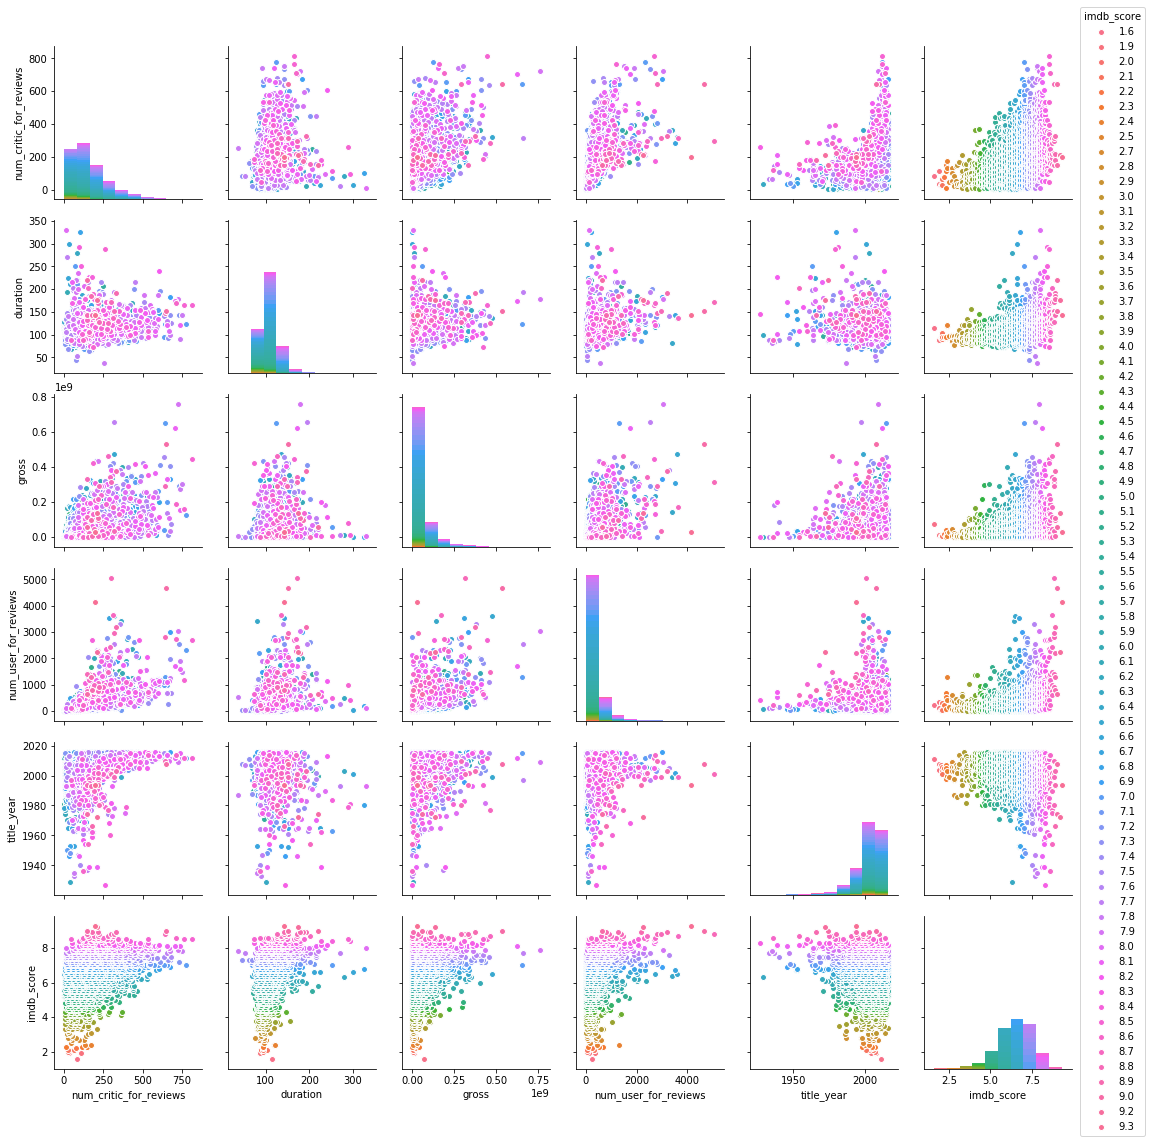

In [12]:
sns.pairplot(imdb_, hue='imdb_score')

É possível observar pelos gráficos plotados que dentre o indicador "num_critic_for_review" e o "num_user_for_review", percebemos que quanto maior o número de críticas e usuários por review, melhor tende a ser a nota do filme. Isso acontece pois, na maioria dos casos, filmes bons acabam recebendo mais atenção dos espectadores, que acabam comentando várias vezes sobre o mesmo sobre os comentários dos outros.

Analisando também a duração de cada filme, vimos que ela influencia em sua nota. É visível que os filmes com uma duração média de 150 minutos são os que possuem notas mais altas. Porém, pode ser observado que há filmes com uma maior e menor duração que também receberam notas elevadas.

Já sobre a receita bruta ("gross") de cada filme, vimos que filmes com receitas brutas maiores tendem a receber notas maiores do que filmes com receitas menores, algo relativamente intuitivo de se pensar.

Agora sobre o ano de lançamento dos filmes, pode-se observar que há uma maior quantidade de dados sobre os filmes mais recentes (1990 em diante), os quais têm uma grande variedade entre notas baixas e altas. Esse cenário é bem diferente do dos filmes mais antigos, os quais se apresentam em menor quantidade no dataset, e os poucos que há, possuem notas, em média, altas, além de ter um maior número de críticas por reviews. Uma possível hipótese que possa explicar esse cenário é que antigamente, quando a indústria de cinema era menor, havia menos filmes sendo lançados anualmente, diferentemente de hoje em dia. Além disso, outra coisa que diferencia os dias atuais de antigamente, é a produção de filmes que recebem notas baixas, como de terror, "comédia trash", entre outros gêneros mais despojados em relação à produção, que servem apenas para causar riso e assustar, possuindo baixos custos e tramas não tão trabalhadas.


In [13]:
def Evaluation (column):
    if column['imdb_score'] >= 8.0 :
        return 'Muito Bom'
    if column['imdb_score'] < 8.0 and column['imdb_score'] >= 6.5:
        return 'Bom'
    if column['imdb_score'] >= 5.0 and column['imdb_score'] < 6.5:
        return 'Neutro'
    if column['imdb_score'] < 5.0 and column['imdb_score'] >= 3.0:
        return 'Ruim'
    if column['imdb_score'] < 3.0:
        return 'Muito Ruim'

In [14]:
imdb_['Evaluation'] = imdb_.apply(lambda column: Evaluation (column), axis=1)

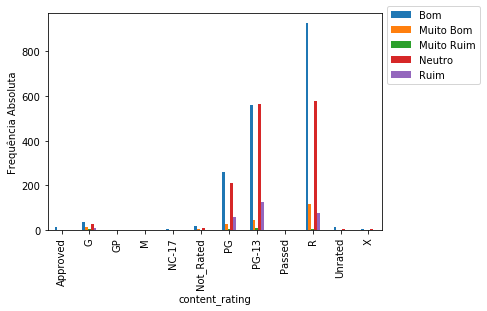

In [15]:
ct1 = pd.crosstab(imdb_.content_rating, imdb_.Evaluation)
ct1.plot(kind='bar')
plt.ylabel('Frequência Absoluta')
plt.legend(loc='center left', bbox_to_anchor=(1,0.85))

Além do já falado acima, observamos que a classificação indicativa tem uma certa relação com a nota que é dada para cada filme. Filmes classificados em R e PG-13, são os que possuem um maior número de notas Boas e Neutras. Os filmes R são os que têm mais avaliações Muito Bom. E os PG-13 são os que possuem um maior número de avaliações Ruim. Dessa forma, pode-se ver que a classificação indicativa de cada filme tem uma certa influência na nota que eles irão receber.

Outra variável que influencia nas notas dos filmes, mas não teve um gráfico plotado, são os gêneros. Os gêneros de cada filme impactam nas notas já que há gêneros que o público tem mais pareço por, como por exemplo, ação, aventura, comédia.

As variáveis, ator 1, 2 e 3 e o diretor, também estão sendo consideradas já que as mesmas causam, talvez, a maior influência na nota de um filme, sendo estes o "core" de qualquer filme. Atores mundialmente conhecidos, que já receberam oscar estão presentes em filmes com uma nota alta, como por exemplo, Meryl Streep, Tom Hanks, Leonardo DiCaprio, etc…

Por fim, podemos concluir que para atingirmos uma noção mais exata do que realmente influencia a nota de um filme será necessário considerar todos esses indicadores juntos, já que essas variáveis não são independentes e o seu conjunto é o que compõem a nota dos filmes.

## Algorítimo: Montando o classificador
#### Iniciando com Naive Bayes Multiclass

Primeiramente classificamos as notas em 5 grupos: Muito Bom, Bom, Neutro, Ruim e Muito Ruim, como foi realizado acima.

In [16]:
imdb2 = imdb_[["director_name", "actor_2_name", 'actor_1_name', 'actor_3_name',"genres", "Evaluation"]]
imdb2['genres'] = imdb2['genres'].apply(lambda x: x.split('|'))
imdb2.head()

C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,director_name,actor_2_name,actor_1_name,actor_3_name,genres,Evaluation
movie_title,,,,,,
Avatar,James_Cameron,Joel_David_Moore,CCH_Pounder,Wes_Studi,"[Action, Adventure, Fantasy, Sci-Fi]",Bom
Pirates of the Caribbean: At World's End,Gore_Verbinski,Orlando_Bloom,Johnny_Depp,Jack_Davenport,"[Action, Adventure, Fantasy]",Bom
Spectre,Sam_Mendes,Rory_Kinnear,Christoph_Waltz,Stephanie_Sigman,"[Action, Adventure, Thriller]",Bom
The Dark Knight Rises,Christopher_Nolan,Christian_Bale,Tom_Hardy,Joseph_Gordon-Levitt,"[Action, Thriller]",Muito Bom
John Carter,Andrew_Stanton,Samantha_Morton,Daryl_Sabara,Polly_Walker,"[Action, Adventure, Sci-Fi]",Bom


In [17]:
imdb_cast = imdb_[["director_name", "actor_2_name", 'actor_1_name', 'actor_3_name']]
imdb_cast.head()

,director_name,actor_2_name,actor_1_name,actor_3_name
movie_title,,,,
Avatar,James_Cameron,Joel_David_Moore,CCH_Pounder,Wes_Studi
Pirates of the Caribbean: At World's End,Gore_Verbinski,Orlando_Bloom,Johnny_Depp,Jack_Davenport
Spectre,Sam_Mendes,Rory_Kinnear,Christoph_Waltz,Stephanie_Sigman
The Dark Knight Rises,Christopher_Nolan,Christian_Bale,Tom_Hardy,Joseph_Gordon-Levitt
John Carter,Andrew_Stanton,Samantha_Morton,Daryl_Sabara,Polly_Walker


In [18]:
notas = imdb2['Evaluation'].values.tolist()
index = round((imdb_cast.index.size)*0.8)

Acabada a limpeza dos dados, tivemos que criar um dataset separado de gêneros, já que os mesmos estavam grudados por “|”, sem espaço entre eles. 

In [19]:
imdb_gen = imdb2.drop(['Evaluation',"director_name", "actor_2_name", 'actor_1_name', 'actor_3_name'], axis=1)

In [20]:
gen = imdb2['genres']

def Generos(lista_gen):
    Genero_1 = []
    Genero_2 = []
    Genero_3 = []
    Genero_4 = []
    Genero_5 = []
    Genero_6 = []
    Genero_7 = []
    for g in lista_gen:
        Genero_1.append(g[0])
        if len(g) < 2:
            Genero_2.append("")
        else:
            Genero_2.append(g[1])
        if len(g) < 3:
            Genero_3.append("")
        else:
            Genero_3.append(g[2])
        if len(g) < 4:
            Genero_4.append("")
        else:
            Genero_4.append(g[3])
        if len(g) < 5:
            Genero_5.append("")
        else:
            Genero_5.append(g[4])
        if len(g) < 6:
            Genero_6.append("")
        else:
            Genero_6.append(g[5])
        if len(g) < 7:
            Genero_7.append("")
        else:
            Genero_7.append(g[6])
    return Genero_1, Genero_2, Genero_3, Genero_4, Genero_5, Genero_6, Genero_7

In [21]:
Genero_1, Genero_2, Genero_3, Genero_4, Genero_5, Genero_6, Genero_7 = Generos(gen)

imdb_gen["Gen1"] = Genero_1
imdb_gen["Gen2"] = Genero_2
imdb_gen["Gen3"] = Genero_3
imdb_gen["Gen4"] = Genero_4
imdb_gen["Gen5"] = Genero_5
imdb_gen["Gen6"] = Genero_6
imdb_gen["Gen7"] = Genero_7
imdb_gen.head()

,genres,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7
movie_title,,,,,,,,
Avatar,"[Action, Adventure, Fantasy, Sci-Fi]",Action,Adventure,Fantasy,Sci-Fi,,,
Pirates of the Caribbean: At World's End,"[Action, Adventure, Fantasy]",Action,Adventure,Fantasy,,,,
Spectre,"[Action, Adventure, Thriller]",Action,Adventure,Thriller,,,,
The Dark Knight Rises,"[Action, Thriller]",Action,Thriller,,,,,
John Carter,"[Action, Adventure, Sci-Fi]",Action,Adventure,Sci-Fi,,,,


In [22]:
index_gen = round((imdb_gen.index.size)*0.8)

In [23]:
imdb_tot = imdb_.drop(['genres','imdb_score'], axis=1)
imdb_tot.head()

,director_name,num_critic_for_reviews,duration,actor_2_name,gross,actor_1_name,actor_3_name,num_user_for_reviews,content_rating,title_year,Evaluation
movie_title,,,,,,,,,,,
Avatar,James_Cameron,723.0,178.0,Joel_David_Moore,760505847.0,CCH_Pounder,Wes_Studi,3054.0,PG-13,2009.0,Bom
Pirates of the Caribbean: At World's End,Gore_Verbinski,302.0,169.0,Orlando_Bloom,309404152.0,Johnny_Depp,Jack_Davenport,1238.0,PG-13,2007.0,Bom
Spectre,Sam_Mendes,602.0,148.0,Rory_Kinnear,200074175.0,Christoph_Waltz,Stephanie_Sigman,994.0,PG-13,2015.0,Bom
The Dark Knight Rises,Christopher_Nolan,813.0,164.0,Christian_Bale,448130642.0,Tom_Hardy,Joseph_Gordon-Levitt,2701.0,PG-13,2012.0,Muito Bom
John Carter,Andrew_Stanton,462.0,132.0,Samantha_Morton,73058679.0,Daryl_Sabara,Polly_Walker,738.0,PG-13,2012.0,Bom


In [24]:
index_tot = round((imdb_tot.index.size)*0.8)

In [25]:
Ytot = notas

In [26]:
imdb_num = imdb_tot[["num_critic_for_reviews", "duration", "gross", "num_user_for_reviews", "title_year"]]
imdb_num.head()

,num_critic_for_reviews,duration,gross,num_user_for_reviews,title_year
movie_title,,,,,
Avatar,723.0,178.0,760505847.0,3054.0,2009.0
Pirates of the Caribbean: At World's End,302.0,169.0,309404152.0,1238.0,2007.0
Spectre,602.0,148.0,200074175.0,994.0,2015.0
The Dark Knight Rises,813.0,164.0,448130642.0,2701.0,2012.0
John Carter,462.0,132.0,73058679.0,738.0,2012.0


Com isso realizado, fomos capazes de criar uma grande lista, com todas as variáveis de string e passa-la no Count Vectorizer e pelo toarray, transformando a lista de strings em uma matriz de 0 e 1. Com isso, concatenamos as variáveis numéricas na matriz. 
Dividimos essa matriz em base de treinamento e teste, 80% e 20% respectivamente. A primeira é usada para treinar os classificadores, e a segunda para testá-los.


In [27]:
numpy_matrix = imdb_num.as_matrix()

In [28]:
print(numpy_matrix)

[[7.23000000e+02 1.78000000e+02 7.60505847e+08 3.05400000e+03
  2.00900000e+03]
 [3.02000000e+02 1.69000000e+02 3.09404152e+08 1.23800000e+03
  2.00700000e+03]
 [6.02000000e+02 1.48000000e+02 2.00074175e+08 9.94000000e+02
  2.01500000e+03]
 ...
 [1.43000000e+02 7.70000000e+01 4.24760000e+05 3.71000000e+02
  2.00400000e+03]
 [5.60000000e+01 8.10000000e+01 2.04092000e+06 1.30000000e+02
  1.99200000e+03]
 [4.30000000e+01 9.00000000e+01 8.52220000e+04 8.40000000e+01
  2.00400000e+03]]


In [29]:
Xgen = imdb_gen['Gen1'] + " " + imdb_gen['Gen2'] + " " + imdb_gen['Gen3'] + " " + imdb_gen['Gen4'] + " " + imdb_gen['Gen5'] + " " + imdb_gen['Gen6'] + " " + imdb_gen['Gen7']

In [30]:
Xtot = Xgen + " " + imdb_tot['director_name'] + " " + imdb_tot['actor_2_name'] + " " + imdb_tot['actor_1_name'] + " " + imdb_tot['actor_3_name'] + " " + imdb_tot['content_rating']

In [31]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(Xtot)

In [32]:
A = X.toarray()

In [33]:
X2 = np.concatenate((A, numpy_matrix), axis=1)

In [34]:
Xtot_treino3 = X2[:index_tot]
Xtot_teste3 = X2[index_tot:]

Ytot_treino3 = Ytot[:index_tot]
Ytot_teste3 = Ytot[index_tot:]

Utilizamos três classificadores diferentes, para ver qual modelo teria o melhor resultado, os quais foram Multinomial Naive Bayes, Random Forest Classifier e Support Vector Classification (SVC).

## MultinomialNB

Aplicação do modelo Multinomial NB. Buscando o quanto o modelo consegue acertar, baseado na base de treinamento que lhe foi passada.

In [35]:
model = MultinomialNB()

In [36]:
model.fit(Xtot_treino3, Ytot_treino3)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
Ytot_pred = model.predict(Xtot_teste3)

acc = accuracy_score(Ytot_teste3, Ytot_pred)
acc

0.05193075898801598

## Random Forest Classifier

Aplicação do modelo Random Forest. Buscando o quanto o modelo consegue acertar, baseado na base de treinamento que lhe foi passada.

In [125]:
# Cria modelo.
model2 = RandomForestClassifier()

In [126]:
model2.fit(Xtot_treino3, Ytot_treino3);

C:\Users\marce\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [127]:
Ytot_pred2 = model2.predict(Xtot_teste3)

acc2 = accuracy_score(Ytot_teste3, Ytot_pred2)
acc2

0.6058588548601864

## SVC

Aplicação do modelo SVC NB. Buscando o quanto o modelo consegue acertar, baseado na base de treinamento que lhe foi passada.

In [41]:
model3 = SVC()

In [42]:
model3.fit(Xtot_treino3, Ytot_treino3);

C:\Users\marce\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [43]:
Ytot_pred3 = model3.predict(Xtot_teste3)

acc3 = accuracy_score(Ytot_teste3, Ytot_pred3)
acc3

0.6045272969374168

## Os Modelos:

##### Multinomial Naive Bayes:
O Multinomial NB é um classificador scikit learn, o qual é uma biblioteca de machine-learning da linguagem de código python que classifica recursos discretos. Ele é utilizado na maioria das vezes para classificar dados que estão em formato de texto. Além disso, esse classificador utiliza contagens de números inteiros, como 1 e 0, mas há alguns casos que ele funciona com valores tf-idf, uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.

Este utiliza o algoritmo de Naive Bayes para classificar uma base de dados distribuída multinomialmente, ou seja, os dados podem trazer mais de dois resultados possíveis. Ele utiliza uma matriz de vetores formada a partir dos textos da base de dados explorada. Essa matriz é composta de 1 e 0, sendo 1 quando alguma palavra tem aparição e 0 quando ela não aparece. 

Assim, a distribuição é parametrizada pelos vetores que foram passados ao classificador, o qual vai observar o número de características que existem, o número de vezes que cada uma delas aparece e o total de características que há na base de dados. O parâmetro final é estimado a partir de uma versão suavizada de máxima verossimilhança entre os dados analisados.

Então, no nosso caso, estamos pegando a maior parte dos nossos dados, os quais são textos, “vetorizamos” e transformamos-os em uma enorme matriz. Adicionamos a essa matriz as características que não são texto, como o número de críticas por usuário e aplicamos isso à biblioteca do python. Então dividimos isso em uma base de treinamento e uma de teste, 80% e 20% respectivamente. Passamos a primeira no modelo para o mesmo aprender e então passamos a base de teste, para ver quanto o modelo acertaria. No caso do Multinomial NB, recebemos um resultado muito baixo, com uma taxa de acertos de apenas 5%. O motivo de isso ocorrer deve-se ao fato do algoritmo Naive Bayes considerar todas as características independentes umas das outras, ou seja, ele não analisa elas em conjunto para chegar em uma resposta. Devido a isso, uma hipótese que temos é que, o modelo não foi capaz de ter uma alta taxa de acertos, pois no nosso caso, a junção de diversas características analisadas conjuntamente é o essencial para dar a nota do filme, e o Naive Bayes, como mencionado anteriormente, não consegue identificar isso. Um exemplo seria que, um filme dirigido por Darren Aronofsky, diretor de Cisne Negro, tendo como principais atores Natalie Portman, Meryl Streep e Hugh Jackman, é um filme com altas probabilidades de ter uma nota alta, mas não por causa de cada ator, individualmente, mas pelo que o conjunto entre esses atores e diretor pode gerar.

###### Random Forest Classifier:
O Random Forest Classifier é um classificador que utiliza um sistema de árvore de decisão, ou seja, ele vai criando “galhos”, sendo cada um deles formados depois de uma decisão tomada. Ele vai dividindo a amostra principal, em diversas subamostras do conjunto de dados. Assim, o modelo vai criando uma grande rede de decisões e amostras (motivo de ser chamado de árvore de decisão), da qual o Random Forest irá usar a média, das subamostras e das decisões, para ter a melhor precisão do modelo.

Vale dizer também que a cada divisão, devido a tomada de decisão, ele não é a melhor decisão entre todas as amostras, mas sim, entre aqueles subconjuntos de amostras.

Devido ao modelo ser um pouco aleatório (Random), ele tende a aumentar o viés, ou seja, tende a sair um pouco da trajetória da resposta mais adequada, entretanto, devido ao uso da média, a variância da resposta diminui, compensando esse desvio, e tornando esse modelo, em geral, melhor que outros.

Então, neste modelo, estamos passando uma matriz, a qual possuiu todas as características de cada filme. Ao passarmos o conjunto de teste, para observar o quanto ele pode acertar, este deve ir analisando os dados e decidindo em qual categoria a informação se encaixa, por exemplo, ele analisou X ator, Y diretor e decidiu que eles eram Muito Bom, tornando essa uma melhor decisão do que dizer que esse conjunto era Neutro. 

Após analisar toda a base de dados, o modelo deve ter realizado a média de suas decisões sobre cada subamostra, e devolvido a resposta sobre a categoria de cada filme. Esse modelo teve uma acurácia de 58-63% de acerto da base de teste que passamos para ele. Uma hipótese é de que o modelo, por causa da média que ele realiza, teve uma maior porcentagem de acerto do que poderia ser. A acurácia poderia ser menor, caso isso não ocorresse.

##### Support Vector Classification (SVC):

O Support Vector Classification ou SVC é um algoritmo supervisionado de Machine Learning usado para desafios de classificação e baseado no libsvm, uma biblioteca para SVMs (Support Vector Machines). Nele, plotamos cada dado como um ponto em um espaço com n dimensões com o valor de cada atributo existente sendo o valor de uma coordenada em particular. Então, para fazer o processo de classificação, acha-se um hiperplano que separa e agrega as diferentes classes. A partir dos hiperplanos formados, o SVC realiza a classificação do dataset.

O modelo bem funciona com datasets menores, sendo muito mais poderoso do que outros métodos para esses casos. Assim, para um número de características com um conjuntos de dados com mais 10.000 amostras o modelo já não funciona tão bem.

Como outros classificadores, o SVC recebe como entrada duas matrizes: uma matriz X contendo as amostras de treinamento e uma matriz Y de rótulos de classe (strings ou int) tendo como tamanho o número de amostras do dataset.

Em nosso caso as duas matrizes passadas foram uma com as características e outra com o resultado de cada filme. Sendo assim, parte delas foram usadas para treinar o modelo e outra parte para verificar se o modelo aprendeu sozinho. Com isto, este método nos retornou uma boa acurácia, com 60% de acertos.


## Como aperfeiçoar os modelos:

Na tentativa de aperfeiçoar o resultado, tentou-se duas coisas. A primeira foi utilizar um dataset muito maior, o qual continha muito mais dados do que o utilizado, o que possibilitaria uma maior base de teste, a qual levaria a uma maior taxa de acertos do modelo. Entretanto, a outra base de dados, estava totalmente sem organização e precisaria de muita atenção para então ser utilizada no projeto. O integrante Bruno, tentou melhorar o dataset o máximo possível para torná-lo usável, porém devido ao curto prazo de tempo, não fomos capazes de utilizar esse segundo dataset. Sugerimos como futura iteração continuar trabalhando nessa base de dados que tem mais de 9 milhões de filmes. 

A outra tentativa de aprimorar o resultado foi colocar o underline (“_”) entre todas as strings (nomes de atores e diretores) que estavam separadas por espaço. Isso foi realizado, pois imaginávamos que o resultado gerado pelo modelo Multinomial Naive Bayes, de 5% de acertos, ocorria pelo fato de, durante o processo, todos os nomes e sobrenomes serem separados, o que influenciava no nome de cada membro do elenco, impedindo o modelo de alcançar uma bom resultado. Entretanto, descobrimos que essa não era a causa, pois mesmo após ter realizado essa alteração, o resultado do modelo não teve alteração alguma.


## Resposta:

<img src="avangers.jpg"/, width=500, height=400 style="float: center; margin: 0px 0px 10px 10px">

Agora, vamos fazer os modelos classificarem um filme que será lançado no ano de 2019.

In [101]:
imdb_x = imdb_.drop(['imdb_score','Evaluation'], axis=1)
novo = pd.DataFrame(data = {'director_name':['Anthony_Russo'], 'num_critic_for_reviews':[800], 'duration':[135], 'actor_2_name':['Robert_Downey_Jr.'], 'gross':[6e+08], 'genres':['Action|Adventure|Sci-Fi'], 'actor_1_name':['Chris_Hemsworth'], 'actor_3_name':['Chris_Evans'], 'num_user_for_reviews':[1500], 'content_rating':['PG-13'], 'title_year':[2018]}, index=["Avengers Infinity War II"])
imdb_x = imdb_x.append(novo)

In [102]:
imdb_x.tail()#.loc[["Avengers Infinity War II"]]

,actor_1_name,actor_2_name,actor_3_name,content_rating,director_name,duration,genres,gross,num_critic_for_reviews,num_user_for_reviews,title_year
The Circle,Fereshteh_Sadre_Orafaiy,Nargess_Mamizadeh,Mojgan_Faramarzi,Not_Rated,Jafar_Panahi,90.0,Drama,673780.0,64.0,26.0,2000.0
Primer,Shane_Carruth,David_Sullivan,Casey_Gooden,PG-13,Shane_Carruth,77.0,Drama|Sci-Fi|Thriller,424760.0,143.0,371.0,2004.0
El Mariachi,Carlos_Gallardo,Peter_Marquardt,Consuelo_Gómez,R,Robert_Rodriguez,81.0,Action|Crime|Drama|Romance|Thriller,2040920.0,56.0,130.0,1992.0
My Date with Drew,John_August,Brian_Herzlinger,Jon_Gunn,PG,Jon_Gunn,90.0,Documentary,85222.0,43.0,84.0,2004.0
Avengers Infinity War II,Chris_Hemsworth,Robert_Downey_Jr.,Chris_Evans,PG-13,Anthony_Russo,135.0,Action|Adventure|Sci-Fi,600000000.0,800.0,1500.0,2018.0


In [103]:
imdb_x['genres'] = imdb_x['genres'].apply(lambda x: x.split('|'))

In [104]:
#Numeros novo
novo_num = imdb_x[["num_critic_for_reviews", "duration", "gross", "num_user_for_reviews", "title_year"]]

#Elenco novo
novo_cast = imdb_x[["director_name", "actor_2_name", 'actor_1_name', 'actor_3_name']]

#Generos novos
novo_totgen = imdb_x[['genres', 'actor_2_name']]
novo_gen = novo_totgen.drop(["actor_2_name"], axis=1)
novo_gen

Genero_n1, Genero_n2, Genero_n3, Genero_n4, Genero_n5, Genero_n6, Genero_n7 = Generos(novo_gen['genres'])

novo_gen["Gen1"] = Genero_n1
novo_gen["Gen2"] = Genero_n2
novo_gen["Gen3"] = Genero_n3
novo_gen["Gen4"] = Genero_n4
novo_gen["Gen5"] = Genero_n5
novo_gen["Gen6"] = Genero_n6
novo_gen["Gen7"] = Genero_n7
novo_gen.tail()

,genres,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7
The Circle,[Drama],Drama,,,,,,
Primer,"[Drama, Sci-Fi, Thriller]",Drama,Sci-Fi,Thriller,,,,
El Mariachi,"[Action, Crime, Drama, Romance, Thriller]",Action,Crime,Drama,Romance,Thriller,,
My Date with Drew,[Documentary],Documentary,,,,,,
Avengers Infinity War II,"[Action, Adventure, Sci-Fi]",Action,Adventure,Sci-Fi,,,,


In [105]:
#CountVectorizer
novo_matrix = novo_num.as_matrix()
NovoXgen = novo_gen['Gen1'] + " " + novo_gen['Gen2'] + " " + novo_gen['Gen3'] + " " + novo_gen['Gen4'] + " " + novo_gen['Gen5'] + " " + novo_gen['Gen6'] + " " + novo_gen['Gen7']
NovoXtot = NovoXgen + " " + novo_cast['director_name'] + " " + novo_cast['actor_2_name'] + " " + novo_cast['actor_1_name'] + " " + novo_cast['actor_3_name'] + " " + imdb_x['content_rating']

NovoX = vectorizer.fit_transform(NovoXtot)
novoA = NovoX.toarray()
NovoX2 = np.concatenate((novoA, novo_matrix), axis=1)

In [106]:
index_x = round((imdb_x.index.size)*0.8)

Xx_treino = NovoX2[:index_x]
Xx_teste = NovoX2[index_x:]

Yx_treino = Ytot[:index_x]

In [107]:
#Modelos
model4 = MultinomialNB()
model4.fit(Xx_treino, Yx_treino)

results = model4.predict(NovoX2)

In [108]:
results[3756]

'Muito Bom'

In [109]:
model5 = RandomForestClassifier()
model5.fit(Xx_treino, Yx_treino)

results2 = model5.predict(NovoX2)

C:\Users\marce\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [110]:
results2[3756]

'Muito Bom'

In [111]:
model6 = SVC()
model6.fit(Xx_treino, Yx_treino)

results3 = model6.predict(NovoX2)

C:\Users\marce\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [112]:
results3[3756]

'Bom'

A primeira resposta, dada pelo modelo Multinomial NB, mesmo parecendo condizente ao observar as variáveis, pode estar  incorreta. Isso pode ocorrer pelo motivo de que o Multinomial NB considera cada variável independente uma da outra, podendo dessa forma afetar o resultado final.

Assim, ficamos com uma certa dúvida sobre qual seria a resposta correta afinal, pois para os outros dois classificadores que tem acurácias semelhantes, próximas a 60%, os resultados obtidos foram diferentes. Contudo, como pegamos um filme recentemente lançado, já avaliado pelo imdb como Muito Bom, mas que não está presente no nosso dataset, concluimos o claasificador Random Forest foi o mais condizente com a realidade nesse caso.

O resultado gerado pelo SVC não foi o esperado, provavelmente pelo fato do modelo ter uma grande margem de erro. Porém não fomos capazes de identificar exatamente o motivo técnico para isso.


## Conclusão:

Após toda a analise e os testes da nossa base de dados em 3 diferentes modelos, vimos que o modelo SVC teve a melhor acurácia. A causa disso, possivelmente é que diferente dos outros dois modelos, um que usa todas as características como independentes, e o outro que usa um sistema de árvore de decisão, que vai priorizando certos sub-grupos sobre outros, o SVC utiliza todas as características e não "abandona" nenhuma no meio do caminho, além de considerar elas como dependentes, fato essencial para a analise desses dados, já que os filmes tem suas notas dadas, de acordo com a composição total, não apenas por uma característica. Por isso, faz sentido ele ter uma acurácia maior que a dos outros modelos.

Com a base de dados que temos, o SVC e o Random Forest são os modelos mais adequados, já que as variáveis são dependentes. O Multinomial NB não é recomendável, algo que é comprovado pela acurácia que ele devolve, pelo fato de ele ver tudo de forma independente.

O nosso projeto pode ser encontrado no seguinte GitHub: https://github.com/TNBSX/Cdados3

**Referências:** 
- https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset *(Link do dataset)*
- https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
- https://scikit-learn.org/stable/index.html